# Clustering Techniques

**Objective:**

Perform different clustering techniques on stock market dataset.

Different clustering methods -

a) K-Means clustering from scratch

b) Hierarchical clustering (not from scratch)

c) Gaussian mixture models clustering (not from scratch)

d) DB Scan clustering (not from scratch) using pycaret library 

**Dataset** - TDAmeritrade

In [6]:
#Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data Collection

In [7]:
import requests
stock_symbols = pd.read_csv('https://pkgstore.datahub.io/core/s-and-p-500-companies-financials/constituents_csv/data/5d62bfc54919c6b7fb69e670c684c4e7/constituents_csv.csv')

# ^ causes error with data so remove it
stock_symbols['Symbol'] = stock_symbols['Symbol'].str.replace('^','')

display(stock_symbols.shape)

# TDMERITRADE provides data in chunks and maximum 120 records can be received at a time. So we are creating chunk of 100 records.
# define the size of the chunk
n = 100
symbols_chunk = [stock_symbols[i:i+n] for i in range( 0, stock_symbols.shape[0], n)]

endpoint = r"https://api.tdameritrade.com/v1/instruments"

stock_dict = {}

# loop through each chunk
for chunk in symbols_chunk:
    
    payload = {'apikey':'AAHJZENLJ2JAS655MEKCFRSYW2WUYKEV',
               'projection':'fundamental',
               'symbol':list(chunk['Symbol'])}
    content = requests.get(url = endpoint, params = payload)

    data = content.json()

    try:
        for stock in data:
            stock_dict[data[stock]['cusip']] = data[stock]['fundamental']
    except:
        continue

# create a data frame with the newly collected data.         
stock_df = pd.DataFrame(stock_dict)

# interchange rows and columns
stock_df = stock_df.transpose()

display(stock_df.head())


(505, 3)

,symbol,high52,low52,dividendAmount,dividendYield,dividendDate,peRatio,pegRatio,pbRatio,prRatio,pcfRatio,grossMarginTTM,grossMarginMRQ,netProfitMarginTTM,netProfitMarginMRQ,operatingMarginTTM,operatingMarginMRQ,returnOnEquity,returnOnAssets,returnOnInvestment,quickRatio,currentRatio,interestCoverage,totalDebtToCapital,ltDebtToEquity,totalDebtToEquity,epsTTM,epsChangePercentTTM,epsChangeYear,epsChange,revChangeYear,revChangeTTM,revChangeIn,sharesOutstanding,marketCapFloat,marketCap,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
037833100,AAPL,157.26,112.59,0.88,0.58,2021-11-05 00:00:00.000,26.93,0.375903,39.316,6.77215,23.3793,41.7794,42.1953,25.8818,24.6533,29.7824,28.5341,147.443,28.0579,42.647,1.02211,1.07455,1829.69,66.4074,172.937,197.684,5.60714,71.6407,68.2212,0,0,33.2594,2.36511,1.64064e+10,16394.8,2.47737e+06,0,0,0,0,0.22,2021-11-11 00:00:00.000,1.21863,5.80649e+07,5.80649e+07,1.59025e+09
115637209,BF/B,82.24,66.25,0.718,1,2021-09-02 00:00:00.000,44.8148,0,12.827,9.292,39.6006,60.3763,61.0375,21.3337,21.192,29.5517,31.8985,31.9057,12.0752,14.3629,2.35525,4.2333,13.1364,48.2446,87.4394,93.2165,1.60371,0,0,0,0,7.8806,11.5763,3.09691e+08,347.838,33581.3,9.92369,0,0,0,0.1795,2021-10-01 00:00:00.000,0.7964,604090,604090,1.83031e+07
031162100,AMGN,276.69,200.47,7.04,3.43,2021-11-15 00:00:00.000,21.154,0,14.1226,4.48982,12.8145,75.422,76.0066,21.7681,28.0942,28.4977,35.4608,58.5002,8.65386,10.7006,1.36289,1.64264,8.03378,82.0574,405.148,457.332,9.70928,0,0,0,0,3.12162,2.7582,5.63266e+08,562.063,115689,0,0,0,0,1.76,2021-12-08 00:00:00.000,0.60728,2.93486e+06,2.93486e+06,5.58721e+07
00508Y102,AYI,224.59,104.84,0.52,0.24,2021-10-14 00:00:00.000,26.0507,0.763212,3.76969,2.20991,18.8201,42.6177,42.2383,8.85004,9.88214,12.3548,13.3777,14.6836,8.6687,10.641,1.65501,2.231,25.2364,19.4698,24.1771,24.1771,8.40669,34.133,46.0484,0,0,4.04954,10.3368,3.49246e+07,34.4965,7648.49,8.88921,0,0,0,0.13,2021-11-01 00:00:00.000,1.61198,231990,231985,6.76753e+06
018802108,LNT,62.35,45.99,1.61,2.88,2021-10-29 00:00:00.000,22.0977,0,2.34214,3.93866,10.8664,40.9449,44.9949,18.1231,25.293,21.7758,28.2227,10.8603,3.59642,3.90708,0.51188,0.65189,6.02083,54.4417,108.197,119.499,2.53375,0,3.73272,0,0,2.30245,25.3366,2.50361e+08,250.123,14017.7,6.38422,0,0,0,0.4025,2021-11-15 00:00:00.000,0.37659,1.18867e+06,1.18867e+06,2.21036e+07


### Data columns selection and filtering

In [8]:
# define our indicators list
metrics_list = ['returnOnEquity','returnOnAssets','returnOnInvestment','symbol']

# select only those columns
indicators_df = stock_df[metrics_list]

# display the unedited DF
display(indicators_df.shape)
display(indicators_df.head())

# eliminate any row that has a missing value.
indicators_df = indicators_df[indicators_df[metrics_list] != 0]
indicators_df = indicators_df.dropna(how='any')

# set the index
indicators_df = indicators_df.set_index('symbol')

display(indicators_df.head())
display(indicators_df.shape)

(460, 4)

,returnOnEquity,returnOnAssets,returnOnInvestment,symbol
037833100,147.443,28.0579,42.647,AAPL
115637209,31.9057,12.0752,14.3629,BF/B
031162100,58.5002,8.65386,10.7006,AMGN
00508Y102,14.6836,8.6687,10.641,AYI
018802108,10.8603,3.59642,3.90708,LNT


,returnOnEquity,returnOnAssets,returnOnInvestment
symbol,,,
AAPL,147.443,28.0579,42.647
BF/B,31.9057,12.0752,14.3629
AMGN,58.5002,8.65386,10.7006
AYI,14.6836,8.6687,10.641
LNT,10.8603,3.59642,3.90708


(364, 3)

### Data wrangling

In [9]:
# define the filters
roe_filter = indicators_df.iloc[:,0] < 40
roa_filter = indicators_df.iloc[:,1] < 30
roi_filter = indicators_df.iloc[:,2] < 30

# get the counts for each column
roe_count = pd.Series(roe_filter).value_counts()
roa_count = pd.Series(roa_filter).value_counts()
roi_count = pd.Series(roi_filter).value_counts()

# display the results
display(roe_count)
display(roa_count)
display(roi_count)

# filter the entire data frame
indicators_df = indicators_df[roe_filter & roa_filter & roi_filter]

# display the results
indicators_df.head()

True     286
False     78
Name: returnOnEquity, dtype: int64

True     358
False      6
Name: returnOnAssets, dtype: int64

True     343
False     21
Name: returnOnInvestment, dtype: int64

,returnOnEquity,returnOnAssets,returnOnInvestment
symbol,,,
BF/B,31.9057,12.0752,14.3629
AYI,14.6836,8.6687,10.641
LNT,10.8603,3.59642,3.90708
BSX,6.86942,3.6893,4.17705
AAP,18.5779,5.42382,9.08374


### Displaying data with scatter plot

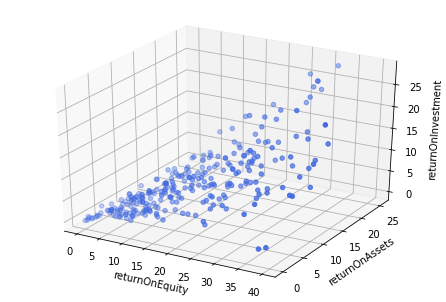

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# define a figure and a 3D axis
fig = plt.figure()
ax = Axes3D(fig)

# define the x, y, & z of our scatter plot, this will just be the data from our data frame.
x = list(indicators_df.iloc[:,0])
y = list(indicators_df.iloc[:,1])
z = list(indicators_df.iloc[:,2])

# define the axis labels
column_names = indicators_df.columns
ax.set_xlabel(column_names[0])
ax.set_ylabel(column_names[1])
ax.set_zlabel(column_names[2])

# define the markers, and the color
ax.scatter(x, y, z, c='royalBlue', marker='o')

plt.show()

### Scaling dimensions to remove outliers

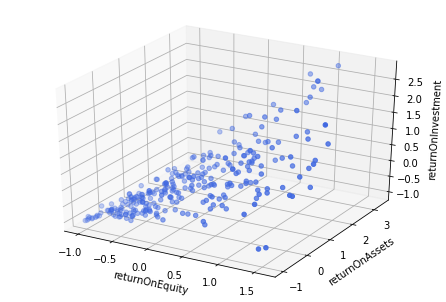

In [11]:
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

# scale the data
X_train_robust = robust_scaler.fit_transform(indicators_df)

# create a new plot
fig = plt.figure()
ax = Axes3D(fig)

# take the scaled data in this example.
x = X_train_robust[:,0]
y = X_train_robust[:,1]
z = X_train_robust[:,2]

# define the axes labels
column_names = indicators_df.columns
ax.set_xlabel(column_names[0])
ax.set_ylabel(column_names[1])
ax.set_zlabel(column_names[2])

# create a new plot
ax.scatter(x, y, z, c='royalBlue')

plt.show()

## K-Means Clustering

**Find out Silhouette Score**

In [12]:
from sklearn.cluster import KMeans
from sklearn import metrics

# define a dictionary that contains all of our relevant info.
results_dict = {}

# define how many clusters we want to test up to.
num_of_clusters = 10

# run through each instance of K
for k in range(2, num_of_clusters):
    
    print("-"*100)
    
    # define the next dictionary to hold all the results of this run.
    results_dict[k] = {}

    # create an instance of the model, and fit the training data to it.
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train_robust)
    
    # define the silhouette score
    sil_score = metrics.silhouette_score(X_train_robust, kmeans.labels_, metric='euclidean')
    
    # store the different metrics
    results_dict[k]['silhouette_score'] = sil_score
    results_dict[k]['inertia'] = kmeans.inertia_
    results_dict[k]['score'] = kmeans.score
    results_dict[k]['model'] = kmeans
    
    # print the results    
    print("Number of Clusters: {}".format(k))
    print('Silhouette Score:', sil_score)
    #print('SSE', kmeans.inertia_)

----------------------------------------------------------------------------------------------------
Number of Clusters: 2
Silhouette Score: 0.5174942563180789
----------------------------------------------------------------------------------------------------
Number of Clusters: 3
Silhouette Score: 0.45929940830236893
----------------------------------------------------------------------------------------------------
Number of Clusters: 4
Silhouette Score: 0.4246164877778258
----------------------------------------------------------------------------------------------------
Number of Clusters: 5
Silhouette Score: 0.41382418417909306
----------------------------------------------------------------------------------------------------
Number of Clusters: 6
Silhouette Score: 0.42307666354773626
----------------------------------------------------------------------------------------------------
Number of Clusters: 7
Silhouette Score: 0.35603606203794896
------------------------------------

**Elbow Method**

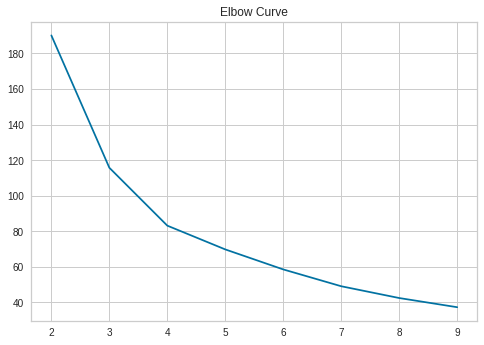

In [15]:
sse = []
for k in range(2,10):
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X_train_robust)
    
    sse.append(kmeans.inertia_) #SSE for each n_clusters
plt.plot(range(2,10), sse)
plt.title("Elbow Curve")
plt.show()

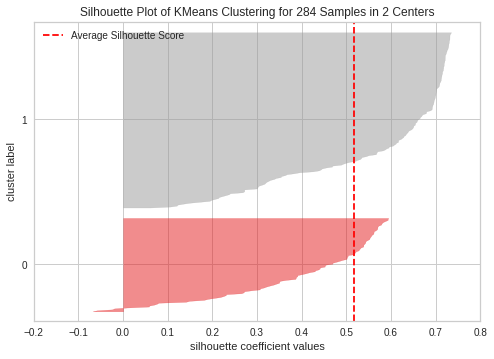

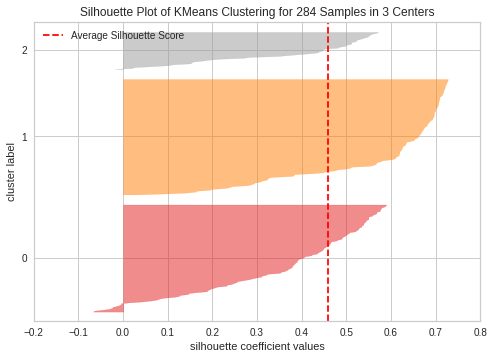

In [13]:
! pip install yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

clusters = [2,3]

for cluster in clusters:
    
    # define the model for K
    kmeans = KMeans(n_clusters = cluster, random_state=0)

    # pass the model through the visualizer
    visualizer = SilhouetteVisualizer(kmeans)

    # fit the data
    visualizer.fit(X_train_robust)

    # show the chart
    visualizer.poof()

**Apply kmeans and plot clusters**

----------------------------------------------------------------------------------------------------


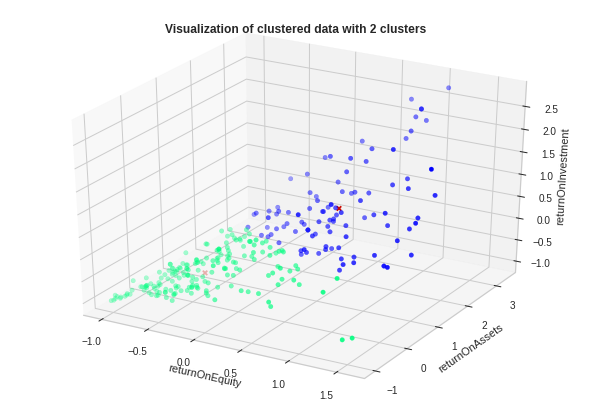

----------------------------------------------------------------------------------------------------


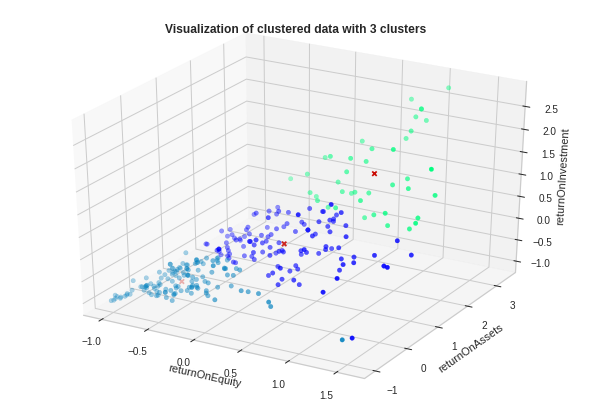

In [14]:
clusters = [2,3]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= cluster, random_state=0).fit(X_train_robust)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]

    # create a new plot
    fig = plt.figure()
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = indicators_df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

**Analysis of KMeans clustering:**

We can see clear clusters of stocks across all 3 attributes. We can analyase highly performing stocks where investors can see those stocks belong to what what cluster and then they can invest on peer companies from some cluster which can give high returns.

## Gaussian Mixture Model

**Find out AIC and BIC to find out number of components**

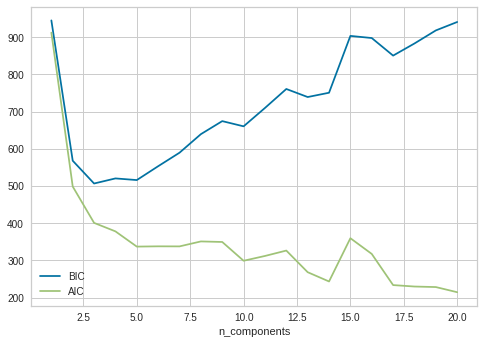

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_train_robust)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train_robust) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train_robust) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

**Apply Gaussian on 2 metrics and plot clusters**

0.19377255580414326

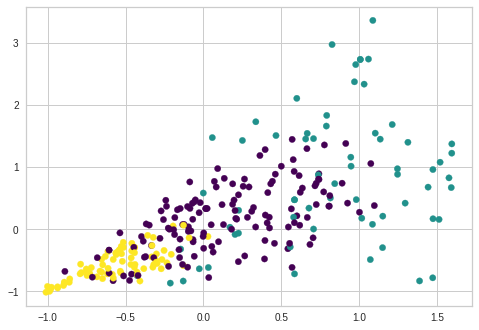

In [17]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
gmm = GaussianMixture(n_components=3).fit(X_train_robust)
labels = gmm.predict(X_train_robust)
plt.scatter(X_train_robust[:, 0], X_train_robust[:, 1], c=labels, s=40, cmap='viridis');
metrics.silhouette_score(X_train_robust, labels, metric='euclidean')

**Apply Gaussian on 3 metrics and plot clusters (check with 2 and 3 components)**

----------------------------------------------------------------------------------------------------


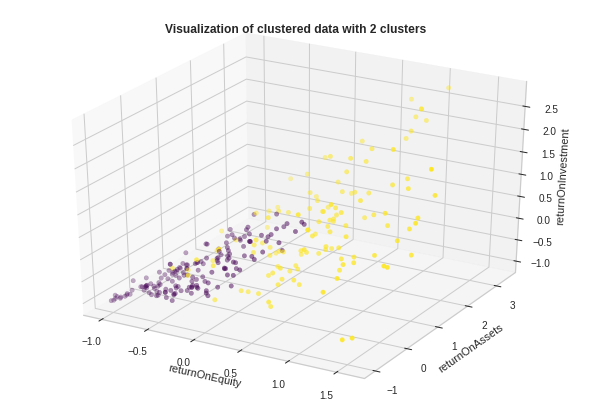

----------------------------------------------------------------------------------------------------


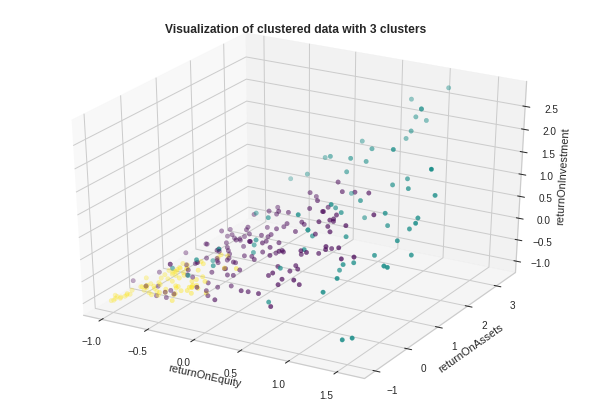

In [19]:
from sklearn.mixture import GaussianMixture
clusters = [2,3]

for cluster in clusters:
    
    print('-'*100)
    gmm = GaussianMixture(n_components=cluster).fit(X_train_robust)
    

    # create a new plot
    fig = plt.figure()
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = indicators_df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    labels = gmm.predict(X_train_robust)
    ax.scatter(x, y, z, c = labels, cmap='viridis')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

**Analysis of Gaussian Mixture Model**

- In gaussian we can see the clusters are overlapping.
- Considering 3 components in gaussian cluster, we can see green cluster is high performing cluster where for most of the companies returnOnEquity, returnOnAssets, returnOnInvestment is high. Purple cluster is having companies that are giving average returns and yellow cluster is having comapines that are giving comparitively low returns. 

##Agglomerative Clustering (Hierarchical Clustering)

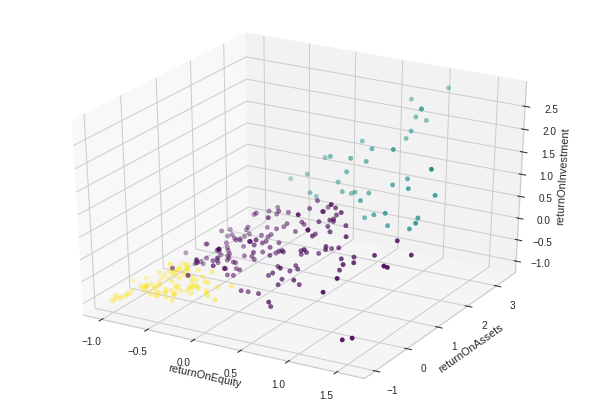

In [20]:
    from sklearn.cluster import AgglomerativeClustering
    hierarchical_model = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean').fit(X_train_robust)
    clust_labels = hierarchical_model.fit_predict(X_train_robust)
    # create a new plot
    fig = plt.figure()
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = indicators_df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = clust_labels, cmap='viridis')


**Analysis of Agglomerative Clustering**

Agglomerative clustering uses a bottom-up approach, wherein each data point starts in its own cluster. These clusters are then joined greedily, by taking the two most similar clusters together and merging them.

## DBScan Clustering

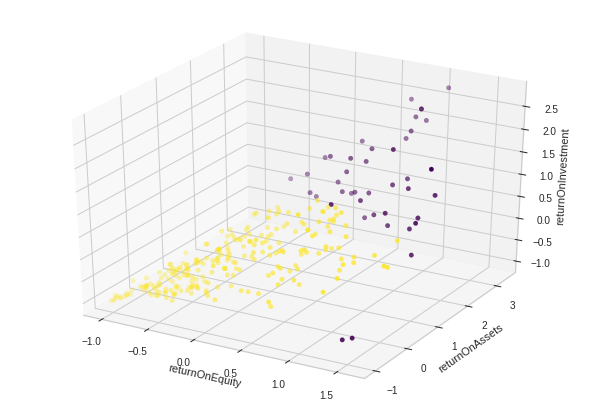

In [39]:
    from sklearn.cluster import DBSCAN 

    db = DBSCAN(eps=1, min_samples=120).fit(X_train_robust)
    clust_labels = db.fit_predict(X_train_robust)
    # create a new plot
    fig = plt.figure()
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = indicators_df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = clust_labels, cmap='viridis')


**Analysis of DBScan Clustering**

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise.Here we can say that a particular point belongs to a cluster, when it is near to lots of other points in that cluster.